In [1]:
%matplotlib inline

import datetime
import glob
import joblib
import os
import time
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import seaborn as sns
# sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#0485d1"]))  # ["jade green", "orange", "blue"] 

In [2]:
# @stevo trik, ked mas viac notebookov, aby ti jeden nb nezozral celu GPU pamat (per_process_gpu_memory_fraction):
import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

## Constants

In [3]:
cfg_teacher_forcing = False  # incremental learning
cfg_remove_peak = False

cfg_sequence_len = 24        # default=24
cfg_sequence_len_y = 1
cfg_steps_ahead = 1

cfg_batch_size = 1
cfg_units = 60              # default=48 GRU units
cfg_dropout_rate = 0.6      # default=0.5

cfg_num_epochs = 100
cfg_num_epochs_update = 2    # incremental learning
cfg_epochs_patience = 10

cfg_fig_size_x = 20
cfg_fig_size_y = 5
 
data_train_filename = 'data/data_train.tsv'
data_test_filename = 'data/data_test.tsv'

model_name = 'models/mods2_model'

## Functions

In [4]:
# pandas dataframe to numpy array
def read_data(filename):
    df = pd.read_csv(filename, sep='\t', skiprows=0, skipfooter=0, engine='python')
    data = df.values
    print('read_data: ', filename, '\t', data.shape[1], data.dtype, '\n', list(df))
    return data


# data is numpy array
def transform(data, epsilon=1, remove_peak=cfg_remove_peak):
    if remove_peak:
        # InterQuartile Range (IQR)
        q_min, q_max = np.percentile(data, [25, 75], axis=0)
        iqr = q_max - q_min
        iqr_min = q_min - 1.5*iqr
        iqr_max = q_max + 1.5*iqr
        data = np.clip(data, a_min=iqr_min, a_max=iqr_max)
    data = np.where(data < 0, epsilon, data)
    return data


# Scale all metrics but each separately: normalization or standardization
def normalize(data, scaler=None):
    if not scaler:
        # scaler = Pipeline([
        #    ('PowerTransformer', PowerTransformer()),
        #    ('MinMaxScaler', MinMaxScaler(feature_range=(0,1))),
        #    ('QuantileTransformer', QuantileTransformer(output_distribution='normal', n_quantiles=100)),
        #])
        scaler = MinMaxScaler(feature_range=(0, 1))
        norm_data = scaler.fit_transform(data)
    else:
        norm_data = scaler.transform(data)
    # print('\nnormalize:', norm_data.shape)
    return norm_data, scaler


def make_timeseries(data,
                    sequence_len=cfg_sequence_len,
                    sequence_len_y=cfg_sequence_len_y,
                    steps_ahead=cfg_steps_ahead
                    ):
    data_x = data_y = data

    if sequence_len_y > 1:
        for i in range(1, sequence_len_y):
            data_y = np.column_stack((data_y[:-1], data[i:]))
        data_x = data_x[:-(sequence_len_y-1)]

    if steps_ahead > 1:
        data_x = data_x[:-(steps_ahead-1)]
        data_y = data_y[steps_ahead-1:]

    tsg_data = TimeseriesGenerator(data_x, data_y, length=sequence_len,
                                   sampling_rate=1, stride=1, batch_size=cfg_batch_size)
    # x, y = tsg_data[0]
    # print('\ttsg x.shape=', x.shape, '\n\tx=', x, '\n\ttsg y.shape=', y.shape, '\n\ty=', y)
    return tsg_data


def transform_invert(data, denorm, sequence_len=cfg_sequence_len, steps_ahead=cfg_steps_ahead):
    begin = sequence_len + steps_ahead -1           # indexing is from 0
    end = begin + len(denorm)
    Y = data[begin:end]                             # excludes the end index
    return denorm, Y


def fit_model(data_train, data_test, model, epochs, scaler, callbacks_list, teacher_forcing=cfg_teacher_forcing):
    trans_train = transform(data_train)
    norm_train, _ = normalize(trans_train, scaler)
    tsg_train = make_timeseries(norm_train)
    
    if teacher_forcing:
        for i in range(epochs):
            history = model.fit(tsg_train, epochs=1, batch_size=cfg_batch_size, shuffle=False, callbacks=callbacks_list)
            model.reset_states()
    else:
        trans_test = transform(data_test)
        norm_test, _ = normalize(trans_test, scaler)
        tsg_test = make_timeseries(norm_test)
        history = model.fit(tsg_train, epochs=epochs, callbacks=callbacks_list, validation_data=tsg_test)
    return model, history


def predict(data_test, model, scaler):
    trans_test = transform(data_test)
    norm_test, _ = normalize(trans_test, scaler)
    tsg_test = make_timeseries(norm_test)
    return model.predict(tsg_test)

## Functions: evaluation + plot

In [5]:
import mods_utils

def eval_predictions(pred_test, Y_test, model_type):
    print('\nEvaluation with real values - One step')
    results = [model_type]

    err_train = err_test = 0
    for m in ['SMAPE', 'MAPE', 'RMSE', 'R2', 'COSINE']:
        if m == 'SMAPE':
            err_test  = mods_utils.smape(Y_test, pred_test)
        elif m == 'RMSE':
            err_test  = mods_utils.rmse(Y_test, pred_test)
        elif m == 'R2':
            err_test  = mods_utils.r2(Y_test, pred_test)
        elif m == 'COSINE':
            err_test  = mods_utils.cosine(Y_test, pred_test)
        results.append([m, err_train, err_test])

    line = results[0]                   # model_type
    for r in results[1:]:
        line += '\t' + r[0] + '\t'      # SMAPE, MAPE, R2, COSINE
        line += '\t'.join(x if isinstance(x, str) else str("{0:0.4f}".format(x)) for x in r[2])  # test
    print(line)
    return line


def plot_predictions(pred_test, Y_test, multivariate,
                     fig_x=cfg_fig_size_x,
                     fig_y=cfg_fig_size_y
                     ):
    plt.rcParams["figure.figsize"] = (fig_x, fig_y)
    if multivariate > 1:
        fig, ax = plt.subplots(multivariate, sharex=False, figsize=(fig_x, multivariate*fig_y))
        for i in range(multivariate):
            ax[i].plot(Y_test[:, i])
            ax[i].plot(pred_test[:, i])
    else:
        fig, ax = plt.subplots(figsize=(fig_x, multivariate*fig_y))
        ax.plot(Y_test[:, 0])
        ax.plot(pred_test[:, 0])

    fig.tight_layout()
    plt.savefig('models/plot_image', bbox_inches='tight')
    plt.show()
    
    # np.savetxt(cfg.app_data_plot + "pred_test.tsv", pred_test, delimiter='\t')
    # np.savetxt(cfg.app_data_plot + "Y_test.tsv", Y_test, delimiter='\t')
    return

## Train data + scaler

In [6]:
data_train = read_data(data_train_filename)
trans_train = transform(data_train)
norm_train, scaler = normalize(trans_train)

# save scaler
scaler_filename = model_name + '.scaler'
joblib.dump(scaler, scaler_filename)
print('Scaler saved to: ', scaler_filename)

read_data:  data/data_train.tsv 	 5 int64 
 ['conn_count_uid_in', 'conn_count_uid_out', 'dns_count_uid_out', 'http_count_uid_in', 'ssl_count_uid_in']
Scaler saved to:  models/mods2_model.scaler


## Test data

In [7]:
data_test = read_data(data_test_filename)

read_data:  data/data_test.tsv 	 5 int64 
 ['conn_count_uid_in', 'conn_count_uid_out', 'dns_count_uid_out', 'http_count_uid_in', 'ssl_count_uid_in']


## Create + compile model

In [8]:
print('Model typ: GRU')
multivariate = data_train.shape[1]

if cfg_teacher_forcing:
    x = Input(batch_shape=(cfg_batch_size, cfg_sequence_len, multivariate))
    h = GRU(units=cfg.units, stateful=True, return_sequences=True)(x)         # activation='tanh'
    h = Dropout(cfg_dropout_rate)(h)
    h = GRU(units=cfg.units, stateful=True, return_sequences=False)(h)
    h = Dropout(cfg_dropout_rate)(h)
    y = Dense(units=multivariate*cfg_sequence_len_y, activation='sigmoid')(h)    
else:
    x = Input(shape=(cfg_sequence_len, multivariate)) 

    h = GRU(units=cfg_units, return_sequences=True)(x)     
    h = Dropout(cfg_dropout_rate)(h)
    h = GRU(units=cfg_units, return_sequences=False)(h)
    h = Dropout(cfg_dropout_rate)(h)
    '''
    h = Dense(units=cfg_units, 
              activation='elu', 
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-5)
             )(x)
    h = Flatten()(h)
    '''      
    # Adding the output layer:
    y = Dense(units=multivariate*cfg_sequence_len_y, activation='sigmoid')(h)
    
model = Model(inputs=x, outputs=y)
print(model.summary())

# compile model
opt = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])     # 'cosine', 'mape'

Model typ: GRU
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 5)]           0         
_________________________________________________________________
gru (GRU)                    (None, 24, 60)            12060     
_________________________________________________________________
dropout (Dropout)            (None, 24, 60)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 305       
Total params: 34,325
Trainable params: 34,325
Non-trainable params: 0
__________________________________________

## Fit + save model

In [9]:
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
earlystops = EarlyStopping(monitor='loss', patience=cfg_epochs_patience, verbose=1)
callbacks_list = [earlystops]

# fit model
model, history = fit_model(data_train, data_test, model, cfg_num_epochs, scaler, callbacks_list)

# save model
model.save(model_name)
print('\nSave trained model: ', model_name)

Epoch 1/100
1402/1402 [==============================] - 15s 9ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0943 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0620
Epoch 2/100
1402/1402 [==============================] - 13s 9ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0765 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0587
Epoch 3/100
1402/1402 [==============================] - 11s 8ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0717 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0561
Epoch 4/100
1402/1402 [==============================] - 14s 10ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0683 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0561
Epoch 5/100
1402/1402 [==============================] - 14s 10ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0679 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0543
Epoch 6/100
1402/1402 [==============================] - 13s 9ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0666 - val_loss: 0.0068 - val_mse: 0.0068 - val_ma

INFO:tensorflow:Assets written to: models/mods2_model/assets


INFO:tensorflow:Assets written to: models/mods2_model/assets



Save trained model:  models/mods2_model


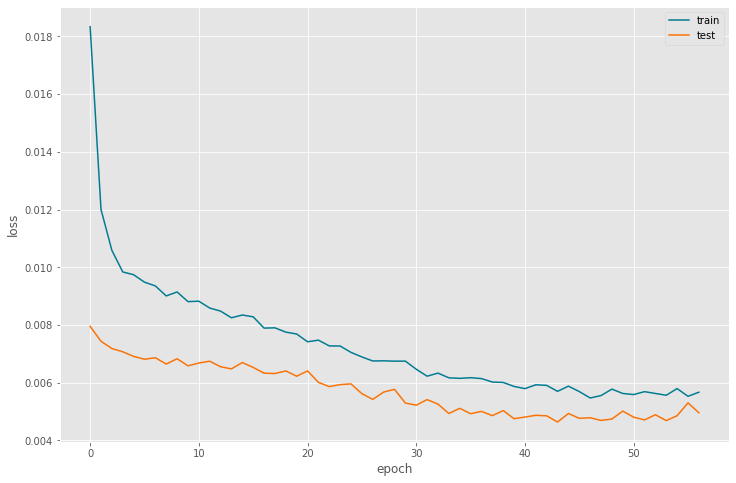

In [10]:
# plot
# print(history.history.keys())
plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Predict and Update: Incremental or Teacher forcing

In [11]:
if cfg_teacher_forcing:
    data_train_copy = data_train
    data_test_copy = data_test
    # data_test_copy = data_test[0:50,:]

    padding = cfg_sequence_len + cfg_steps_ahead + cfg_sequence_len_y -1
    pred_model = None

    for i in range(data_test_copy.shape[0] - padding):
        if i > 0:
            fit_model(data_train_copy, model, cfg_num_epochs_update, scaler, callbacks_list)
        data = data_test[i:i+padding,:]
        pred = predict(data, model, scaler)
        pred_model = np.vstack((pred_model, pred)) if pred_model is not None else pred
        
        # TODO: peak detection
        data = transform(data)
        data_train_copy = np.vstack((data_train_copy, data))    
        print(i)
        
    # Save incremental model
    model_name = model_name + '_incremental'
    model.save(model_name)
    print('\nSave trained model: ', model_name)
    
    # Evaluation + plot (incremental)
    eval_line = ''
    for i in range(cfg_sequence_len_y):
        one_y_test = pred_model[:, i * multivariate:(i+1) * multivariate]
        denorm_test = scaler.inverse_transform(one_y_test)
        pred_test, Y_test = transform_invert(data_test, denorm_test, cfg_sequence_len, cfg_steps_ahead)

        # Evaluate with real values
        eval_line += str(i+1) + '\t' + eval_predictions(pred_test, Y_test, 'LSTM') + '\n'

        # Plot
        plot_predictions(pred_test, Y_test, multivariate)

## Predict + Evaluation + Plot


Evaluation with real values - One step
NN	SMAPE	17.7214	13.2703	49.3849	48.4936	12.3307	MAPE	17.7214	13.2703	49.3849	48.4936	12.3307	RMSE	3306.6866	342.7160	201.0542	894.2397	61.0921	R2	0.5468	0.3303	0.5091	0.5296	0.1807	COSINE	0.9683	0.9869	0.8938	0.8409	0.9788


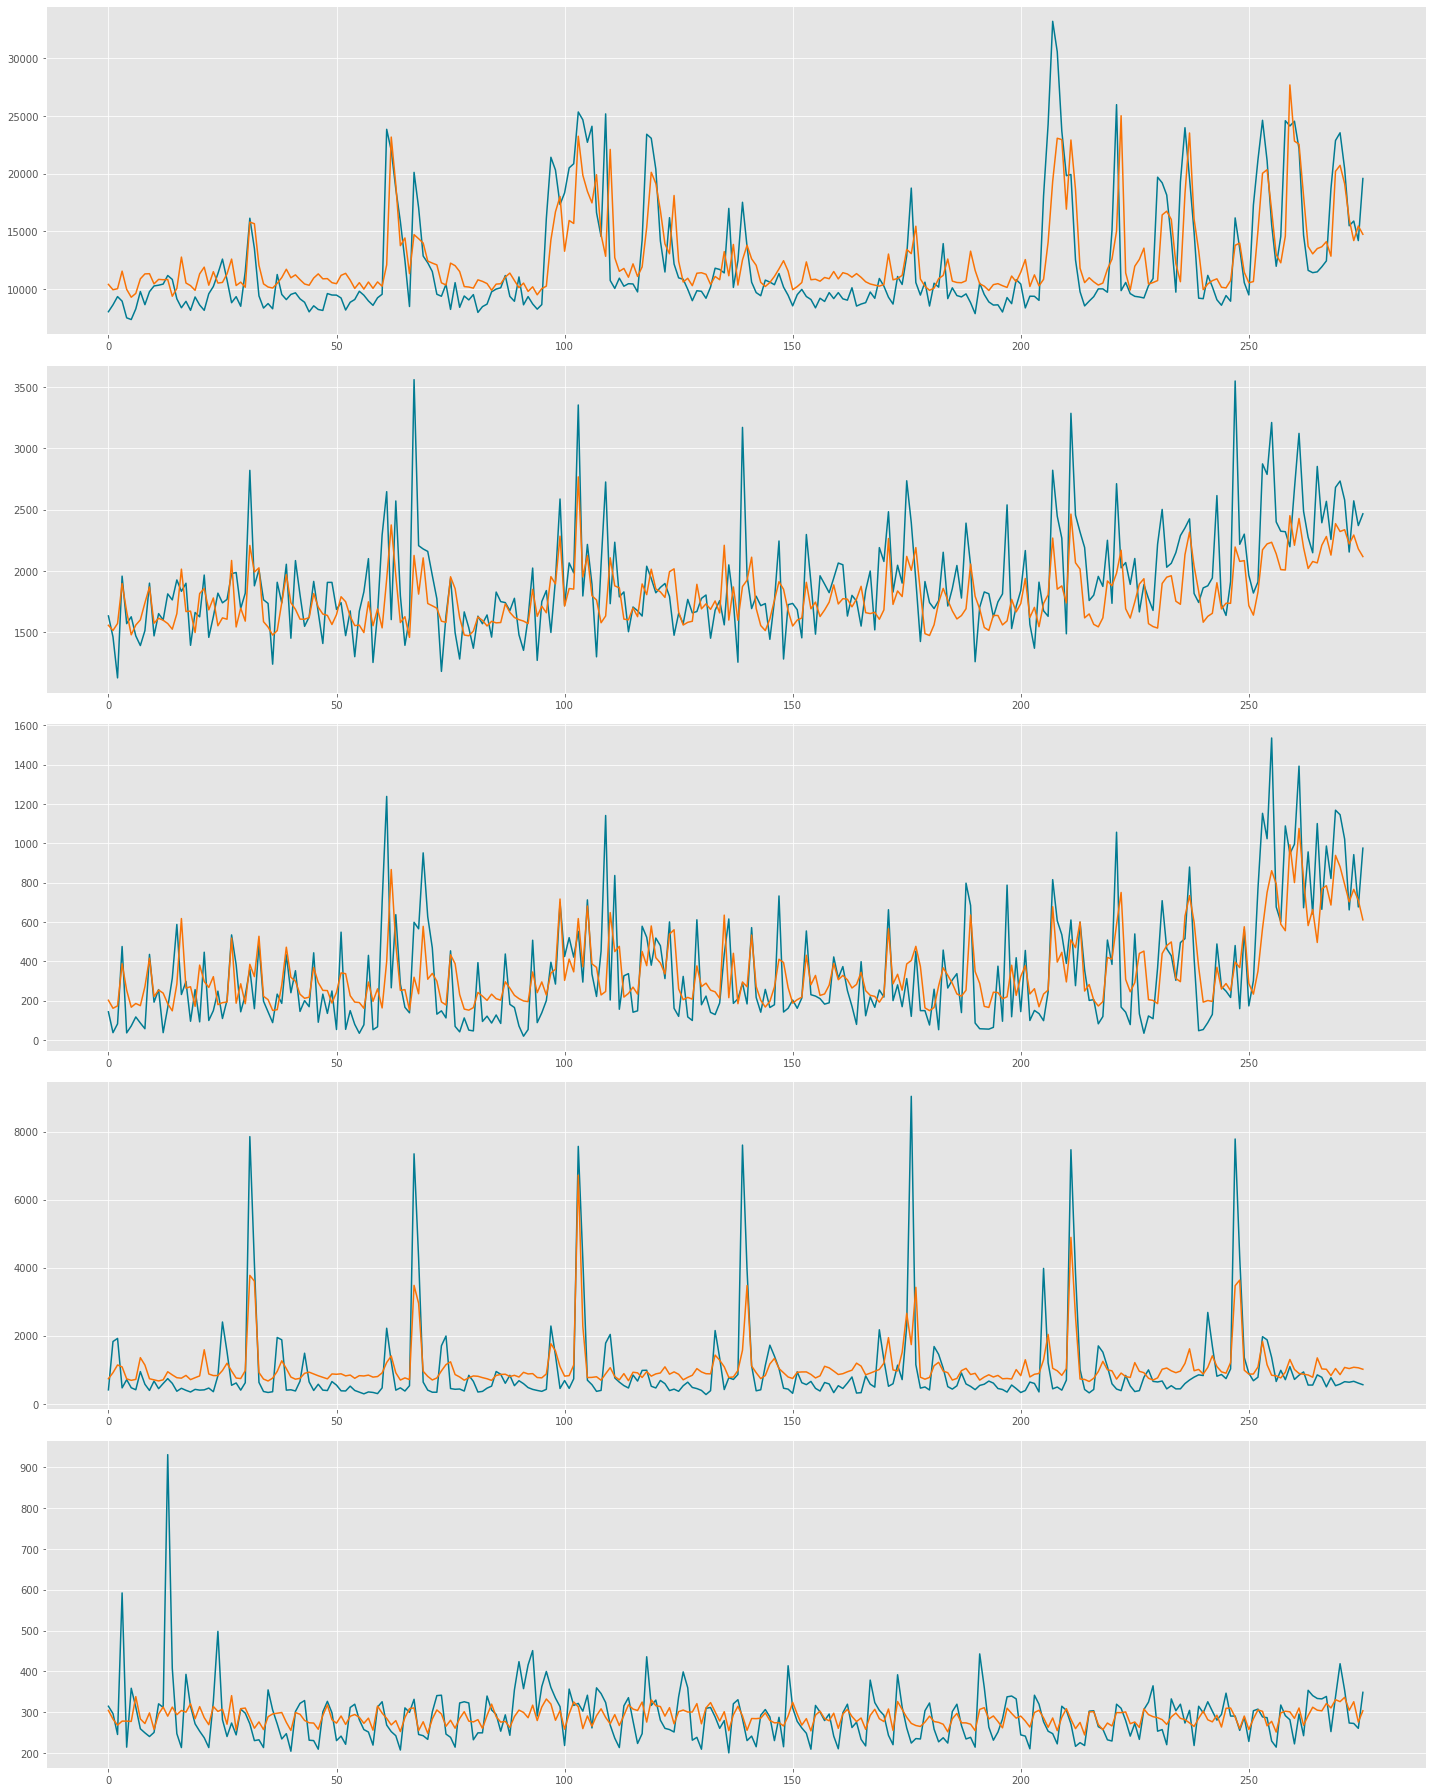

In [12]:
pred_model = predict(data_test, model, scaler)

eval_line = ''
for i in range(cfg_sequence_len_y):
    one_y_test = pred_model[:, i * multivariate:(i+1) * multivariate]
    denorm_test = scaler.inverse_transform(one_y_test)
    pred_test, Y_test = transform_invert(data_test, denorm_test, cfg_sequence_len, cfg_steps_ahead)

    # Evaluate with real values
    eval_line += str(i+1) + '\t' + eval_predictions(pred_test, Y_test, 'NN') + '\n'
    
# Plot
if cfg_sequence_len_y == 1:
    plot_predictions(pred_test, Y_test, multivariate)

# Optimization

In [13]:
opt = True
